In [1]:
import numpy as np
import pickle

import skimage.io as skio
import skimage.transform as skit
import skimage.measure as skim
import scipy.optimize as scpo

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
new_style = {'grid': False}
plt.rc('axes', **new_style)

import pulse2percept as p2p

2017-04-19 22:44:44,216 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
class InterpSim(p2p.Simulation):
    def __init__(self, implant, name=None, engine='joblib', dojit=True, num_jobs=-1):
        if not isinstance(implant, p2p.implants.ElectrodeArray):
            e_s = "`implant` must be of type p2p.implants.ElectrodeArray"
            raise TypeError(e_s)

        self.name = name
        self.implant = implant
        self.engine = engine
        self.dojit = dojit
        self.num_jobs = num_jobs

        # Optic fiber layer (OFL): After calling `set_optic_fiber_layer`, this
        # variable will contain a `p2p.retina.Grid` object.
        self.ofl = None

        # Ganglion cell layer (GCL): After calling `set_ganglion_cell_layer`,
        # this variable will contain a `p2p.retina.TemporalModel` object.
        self.gcl = None
        
    def set_ganglion_cell_layer(self, loadfile):
        from scipy.interpolate import RegularGridInterpolator
        import pickle
        
        in_list, out_list = pickle.load(open(loadfile, 'rb'))
        in_arr = np.array(in_list)
        amps = np.unique(in_arr[:, 0])
        freqs = np.unique(in_arr[:, 1])
        ecs = np.unique(in_arr[:, 2])
        out_arr = np.array(out_list).reshape((len(amps), len(freqs), len(ecs)))

        self.gcl = RegularGridInterpolator((amps, freqs, ecs), out_arr,
                                           bounds_error=False, fill_value=None)
        
    def pulse2percept(self, amps, freq, layers=['OFL', 'GCL']):
        if 'OFL' in layers:
            ecs, _ = self.ofl.electrode_ecs(self.implant)
        else:
            _, ecs = self.ofl.electrode_ecs(self.implant)
            
        # Sum up current contributions from all electrodes
        ecs = np.sum(ecs[:, :, 1, :] * amps.flatten(), axis=-1)
        
        out_list = np.array([self.gcl([a, freq, 1]) for a in ecs.flatten()])
        out_list[ecs.flatten() < 0] = 0.0
        return out_list.reshape(ecs.shape)

In [3]:
def calc_ssim(target, pred):
    return skim.compare_ssim(target / target.max(),
                             pred / pred.max(),
                             data_range=1.0,
                             gaussian_weights=True, sigma=1.5,
                             use_sample_covariance=False)

In [4]:
def calc_error_lasso(target, pred, amps, N, alpha=1.0):
    reconst = 1.0 / (2.0 * N) * skim.compare_mse(target, pred)
    regular = np.sum(np.abs(pred))
    
    return reconst + alpha * regular

In [5]:
def calc_error(target, pred, amps, mode='ssim', lmb=0.0001):
    # reconstruction error
    if mode.lower() == 'ssim':
        reconst = (1.0 - calc_ssim(target, pred)) / 2.0
    elif mode.lower() == 'rmse':
        reconst = skim.compare_nrmse(target / target.max(), pred / pred.max())
    else:
        raise NotImplementedError

    # regularization
    regular = np.linalg.norm(amps.flatten())
    
    return reconst + lmb * regular

In [6]:
def step_model(amps, target, sim, layers, N=1, alpha=1.0):
    pred = sim.pulse2percept(amps, 20, layers=layers)
    err = calc_error_lasso(target, pred, amps, N, alpha)
    if np.random.rand() < 0.1:
        print(err)
    return err

In [7]:
def plot_results(img_in, img_out, img_target, lmb=0.0001):
    ssim = calc_ssim(img_target, img_out)
    err = calc_error(img_target, img_out, img_in, mode='rmse', lmb=lmb)
    plt.subplot(131)
    plt.imshow(img_in.reshape((6, 10)), cmap='gray')
    plt.title('in')
    plt.subplot(132)
    plt.imshow(img_out, vmin=0, cmap='gray')
    plt.title('ssim=%.3f err=%.3f' % (ssim, err))
    plt.subplot(133)
    plt.imshow(img_target, cmap='gray')
    plt.title('target')

In [8]:
letter = 'G'
layers = ['GCL', 'OFL']
mode = 'rmse'
lmb = 0.0
layerstr = '-'.join(layers)

letterfile = 'letters/%s.jpg' % letter
picklefile = 'xopt-%s-%f-%s-%s.dat' % (mode, lmb, letter, layerstr)

In [9]:
implant = p2p.implants.ArgusII()

In [10]:
# The approximated model, interpolated from an input-output function
sim = InterpSim(implant)
sim.set_optic_fiber_layer(sampling=200)
sim.set_ganglion_cell_layer('temporal-model-amps-freqs-ecs.dat')
sim.gcl.grid

(array([   0.,    5.,   10.,   15.,   20.,   25.,   30.,   35.,   40.,
          45.,   50.,   55.,   60.,   65.,   70.,   75.,   80.,   85.,
          90.,   95.,  100.]),
 array([   0.,   10.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,
          90.,  100.,  110.,  120.,  130.,  140.,  150.,  160.,  170.,
         180.,  190.,  200.]),
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
         1.1,  1.2,  1.3,  1.4,  1.5]))

In [11]:
img = 255 - skio.imread(letterfile)
img.shape, img.min(), img.max()

((200, 256), 0, 255)

In [12]:
img = img[50:150, 70:190]
img_small = skit.resize(img, (6, 10))
img_small.shape, img_small.min(), img_small.max()

((6, 10), 0.0, 1.0)

In [13]:
target = skit.resize(img, sim.ofl.gridx.shape)
target /= target.max()
target *= 25.0
target.shape, target.min(), target.max()

((21, 31), 0.0, 25.0)

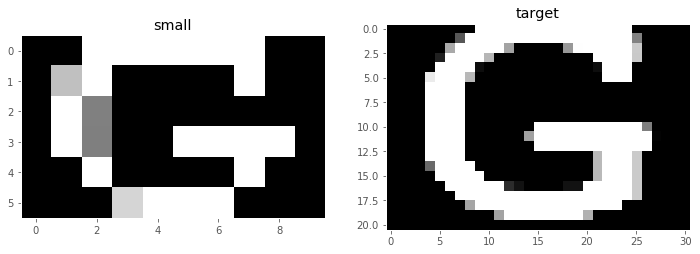

In [14]:
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(img_small, cmap='gray')
plt.title('small')
plt.subplot(122)
plt.imshow(target, cmap='gray')
plt.title('target')

In [15]:
assert calc_error(target, target, np.zeros(10), 'ssim', 0.1) == 0.0
assert np.isclose(calc_error(target, target, np.ones(2), 'ssim', 0.25), 0.25 * np.sqrt(2))

In [16]:
xopt = scpo.fmin(step_model, img_small, args=(target, sim, layers, 1, 0.1))

160.326117206
160.443796945
160.478932349
160.579902288
160.326596587
160.034522829
159.895645124
159.767414304
159.372094434
159.627363456
159.566012104
159.178997415
159.043006597
159.035582614
158.872137263
158.789968235
158.709658307
158.47722084
158.466920125
158.410775374
158.398227628
158.138517261
158.101462493
158.061246361
157.982257868
157.800176614
157.754732457
157.722989656
157.657485404
157.412634087
157.174605298
157.153954856
157.005647057
156.914865263
156.782953513
156.741513989
156.124642483
156.589543555
156.505797578
156.26831946
156.238247006
156.068680596
156.040836002
155.992155567
155.632233964
155.442089164
155.393818489
155.309178862
155.011102177
154.879713891
154.722660836
154.106737221
153.93676705
153.472396344
153.386778909
153.225653076
152.92291701
152.924325133
152.897075351
152.86334132
152.711547655
152.664080239
152.480153664
152.20000609
152.109029466
151.730073175
151.384548318
151.138264581
151.036431616
150.057728881
150.671479018
149.92516167

In [17]:
xopt.min(), xopt.max()

AttributeError: 'numpy.ndarray' object has no attribute 'x'

In [ ]:
pickle.dump(xopt, open(picklefile, 'wb'))

In [ ]:
out_opt = sim.pulse2percept(xopt, 20, layers=layers)
out_opt.shape

In [ ]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.imshow(img_small, cmap='gray')
plt.title('in')
plt.subplot(132)
plt.imshow(out_opt, cmap='gray')
plt.title('struct sim: %.3f' % skim.compare_ssim(out_opt / out_opt.max(), target / target.max(), dynamic_range=1.0))
plt.subplot(133)
plt.imshow(target, cmap='gray')
plt.title('target')